<a href="https://colab.research.google.com/github/marreapato/Forecasting_Paper_XAI/blob/main/stocks_type_lags/MultivariateStocks_Baseline_Com_Lags_tryingshaplime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=448bafaa4ba9ae60ee83543acf35801ab2a54d9b103042baeb60030439260c29
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, GRU, Reshape# captum (biblioteca de interpretação pytorch)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import shap
#from tensorflow.compat.v1.keras.backend import get_session

tf.compat.v1.disable_v2_behavior() # caracteristica necessaria para o uso shap

# Download data for the stock (I'm using the Bovespa index as an example)
data = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data.head()




Instructions for updating:
non-resource variables are not supported in the long term
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200
2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800
2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000
2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000
2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100


In [3]:
sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "structured_data"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
feriados = pd.read_csv(url)
feriados = feriados.drop("Unnamed: 4", axis = 1)
feriados

,Date,4_observance,4_optional,4_public
0,2007-01-01,0,0,1
1,2007-01-02,0,0,1
2,2007-02-17,0,1,0
3,2007-02-18,0,1,0
4,2007-02-19,0,1,0
...,...,...,...,...
697,2024-12-25,0,1,0
698,2024-12-25,0,0,1
699,2024-12-26,0,0,1
700,2024-12-31,0,1,0


In [4]:
data.reset_index(inplace=True)


In [5]:
feriados['Date']=feriados.Date.astype('datetime64[ns]')

In [6]:
data=data.merge(feriados, on='Date', how='left')

In [7]:
data['4_observance'] = data['4_observance'].fillna(0)
data['4_public'] = data['4_public'].fillna(0)
data['4_optional'] = data['4_optional'].fillna(0)

In [8]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,4_observance,4_optional,4_public
0,2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200,0.0,0.0,1.0
1,2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800,0.0,0.0,0.0
2,2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000,0.0,0.0,0.0
3,2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000,0.0,0.0,0.0
4,2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100,0.0,0.0,0.0


In [67]:
sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "Selic"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
selic = pd.read_csv(url)
selic = selic.drop("fonte", axis = 1)
selic

,Date,selic
0,24/01/2007,1
1,07/03/2007,1
2,18/04/2007,1
3,06/06/2007,1
4,18/07/2007,1
...,...,...
129,22/03/2023,1
130,03/05/2023,1
131,21/06/2023,1
132,02/08/2023,1


In [68]:
selic['Date'] = pd.to_datetime(selic['Date'])
selic['Date'].dt.strftime('%Y-%m-%d')

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.


0      2007-01-24
1      2007-07-03
2      2007-04-18
3      2007-06-06
4      2007-07-18
          ...    
129    2023-03-22
130    2023-03-05
131    2023-06-21
132    2023-02-08
133    2023-09-20
Name: Date, Length: 134, dtype: object

In [69]:
data=data.merge(selic, on='Date', how='left')
data['selic'] = data['selic'].fillna(0)
data.head()#SELIC WAS ADDED HERE

,Date,Open,High,Low,Close,Adj Close,Volume,4_observance,4_optional,4_public,selic
0,2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200,0.0,0.0,1.0,0.0
1,2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800,0.0,0.0,0.0,0.0
2,2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000,0.0,0.0,0.0,0.0
3,2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000,0.0,0.0,0.0,0.0
4,2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100,0.0,0.0,0.0,0.0


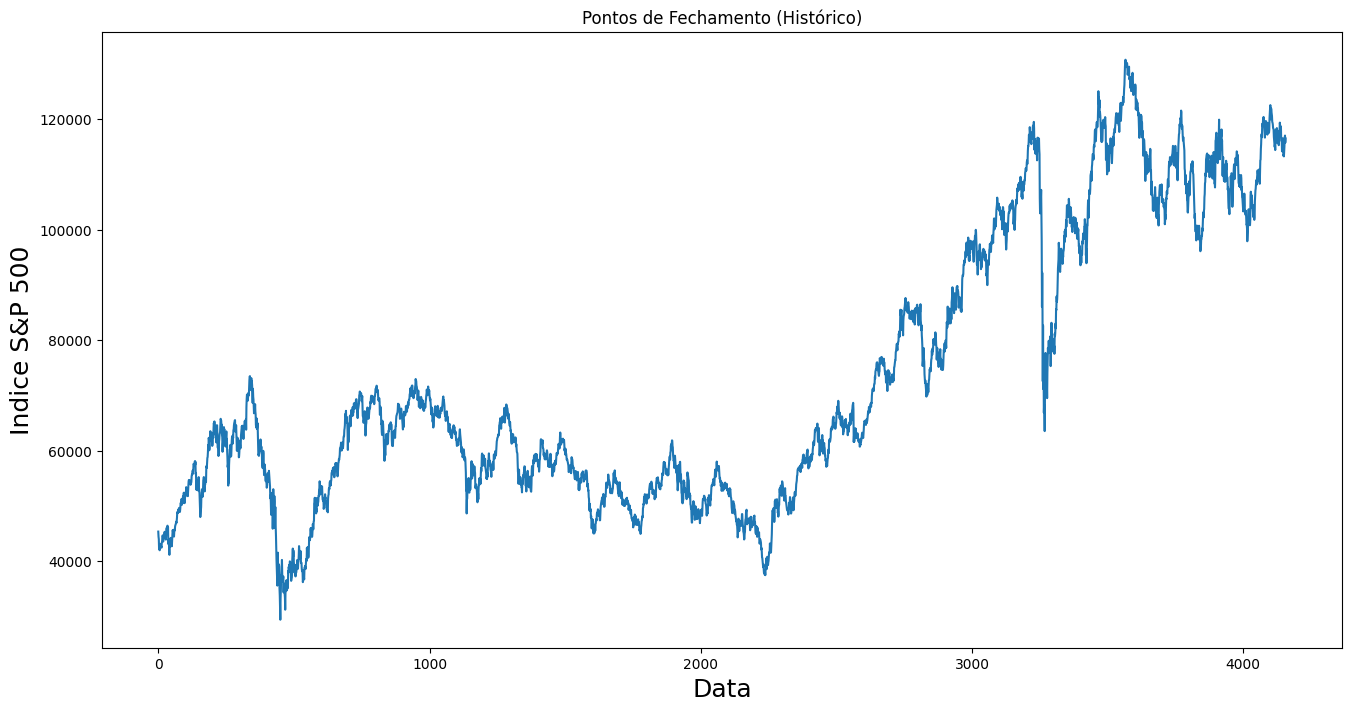

In [70]:
plt.figure(figsize=(16,8))
plt.title("Pontos de Fechamento (Histórico)")
plt.plot(data["Close"])
plt.xlabel("Data",fontsize=18)
plt.ylabel("Indice S&P 500",fontsize=18)
plt.show()

In [71]:
look_back=6

In [72]:
last_rows=(len(data['Close'])-look_back)-int((len(data['Close'].values.reshape(-1, 1)[:])-look_back)*0.8)
last_rows

831

In [73]:
size_of_slice=round((len(data['Close'].values.reshape(-1, 1)[:]))*0.8)
size_of_slice=size_of_slice+(len(data)-(size_of_slice+last_rows))
size_of_slice



3326

In [74]:
data['Close']

0        45383.0
1        44445.0
2        44020.0
3        42245.0
4        42830.0
          ...   
4152    115156.0
4153    116737.0
4154    117051.0
4155    115754.0
4156    116534.0
Name: Close, Length: 4157, dtype: float64

In [75]:
# Normalize the data
closescaler = MinMaxScaler()

data_train=pd.DataFrame(closescaler.fit_transform(data['Close'].values[0:size_of_slice].reshape(-1, 1)),
                        columns=['Close'],index=data['Close'].index[0:size_of_slice])#use fit only in training that is wrong
data_test=pd.DataFrame(closescaler.transform(data['Close'].values[size_of_slice:size_of_slice+last_rows].reshape(-1, 1)),
                       columns=['Close'],index=data['Close'].index[size_of_slice:size_of_slice+last_rows])#use fit only in training that is wrong

In [15]:
train_datanscal = data.iloc[0:size_of_slice]
test_datanscal = data.iloc[size_of_slice:size_of_slice+last_rows]

In [16]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       '4_observance', '4_optional', '4_public'],
      dtype='object')

In [17]:
# Normalize the data
scaler = MinMaxScaler()

train_datanscal[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       '4_observance', '4_optional', '4_public']] = scaler.fit_transform(train_datanscal[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       '4_observance', '4_optional', '4_public']])
train_datanscal.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Open,High,Low,Close,Adj Close,Volume,4_observance,4_optional,4_public
0,2007-01-02,0.166922,0.157843,0.169623,0.177017,0.177017,0.325319,0.0,0.0,1.0
1,2007-01-03,0.176945,0.157741,0.167458,0.166606,0.166606,0.526866,0.0,0.0,0.0
2,2007-01-04,0.166545,0.147107,0.160004,0.161888,0.161888,0.372750,0.0,0.0,0.0
3,2007-01-05,0.161849,0.143010,0.143505,0.142186,0.142186,0.706326,0.0,0.0,0.0
4,2007-01-08,0.142202,0.129901,0.143324,0.148680,0.148680,0.490849,0.0,0.0,0.0


In [18]:
test_datanscal[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       '4_observance', '4_optional', '4_public']] = scaler.transform(test_datanscal[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       '4_observance', '4_optional', '4_public']])
test_datanscal.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Open,High,Low,Close,Adj Close,Volume,4_observance,4_optional,4_public
3326,2020-06-16,0.698735,0.723344,0.709934,0.711443,0.711443,0.051812,0.0,0.0,0.0
3327,2020-06-17,0.711433,0.739176,0.722836,0.733819,0.733819,0.047940,0.0,0.0,0.0
3328,2020-06-18,0.733811,0.744839,0.735996,0.740235,0.740235,0.043091,0.0,0.0,0.0
3329,2020-06-19,0.740371,0.749719,0.749259,0.745197,0.745197,0.056549,0.0,0.0,0.0
3330,2020-06-22,0.745188,0.742115,0.737925,0.731477,0.731477,0.035583,0.0,0.0,0.0


In [19]:
data_train=train_datanscal.append(test_datanscal)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [20]:
data_train.shape

(4157, 10)

In [21]:
len(data_train)==len(data)

True

In [22]:
data_train.shape

(4157, 10)

In [23]:
# Normalize the data
#scaler = MinMaxScaler()
#data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))#use fit only in training that is wrong


def create_lagged_dataframe(data, lags, include_lag0=False):
    lagged_data = data.copy()

    if include_lag0:
        lagged_data['lag0'] = lagged_data['Close']

    for lag in range(1, lags + 1):
        lagged_data[f'lag{lag}'] = lagged_data['Close'].shift(lag)

    return lagged_data
# Split the data into train and test sets


# Create lag features for the entire dataset
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data = create_lagged_dataframe(data_train, look_back, include_lag0)
lagged_data = lagged_data.dropna()  # Drop rows with NaN values

train_size = int(len(lagged_data) * 0.8)
test_size = len(lagged_data) - train_size
train, test = lagged_data[0:train_size], lagged_data[train_size:len(data)]

In [24]:
lagged_data.head(-1)

,Date,Open,High,Low,Close,Adj Close,Volume,4_observance,4_optional,4_public,lag1,lag2,lag3,lag4,lag5,lag6
6,2007-01-10,0.139449,0.123205,0.133423,0.143196,0.143196,0.476851,0.0,0.0,0.0,0.139545,0.148680,0.142186,0.161888,0.166606,0.177017
7,2007-01-11,0.143168,0.132194,0.141024,0.146904,0.146904,0.362369,0.0,0.0,0.0,0.143196,0.139545,0.148680,0.142186,0.161888,0.166606
8,2007-01-12,0.146864,0.132875,0.147632,0.151621,0.151621,0.416947,0.0,0.0,0.0,0.146904,0.143196,0.139545,0.148680,0.142186,0.161888
9,2007-01-15,0.151593,0.136109,0.151568,0.149668,0.149668,0.193864,0.0,0.0,0.0,0.151621,0.146904,0.143196,0.139545,0.148680,0.142186
10,2007-01-16,0.149606,0.129788,0.146381,0.146393,0.146393,0.400785,0.0,0.0,0.0,0.149668,0.151621,0.146904,0.143196,0.139545,0.148680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4151,2023-10-06,0.930680,0.942097,0.926595,0.940528,0.940528,0.056565,0.0,0.0,0.0,0.930694,0.934279,0.932192,0.950374,0.967112,0.957855
4152,2023-10-09,0.940515,0.950359,0.947447,0.951472,0.951472,0.040791,0.0,0.0,0.0,0.940528,0.930694,0.934279,0.932192,0.950374,0.967112
4153,2023-10-10,0.951493,0.969437,0.966732,0.969021,0.969021,0.050035,0.0,0.0,0.0,0.951472,0.940528,0.930694,0.934279,0.932192,0.950374
4154,2023-10-11,0.969020,0.971695,0.978832,0.972506,0.972506,0.042838,0.0,0.0,0.0,0.969021,0.951472,0.940528,0.930694,0.934279,0.932192


In [25]:
trainX= train.drop(columns=['Close','Date']).values
testX = test.drop(columns=['Close','Date']).values
trainY= train['Close'].values
testY= test['Close'].values

print("TrainX shape:", trainX.shape)
print("TrainY shape:", trainY.shape)
print("TestX shape:", testX.shape)
print("TestY shape:", testY.shape)

TrainX shape: (3320, 14)
TrainY shape: (3320,)
TestX shape: (831, 14)
TestY shape: (831,)


In [26]:
trainX

array([[0.13944944, 0.12320543, 0.1334228 , ..., 0.16188827, 0.16660562,
        0.17701708],
       [0.14316794, 0.13219389, 0.14102376, ..., 0.14218641, 0.16188827,
        0.16660562],
       [0.14686425, 0.13287483, 0.14763231, ..., 0.1486797 , 0.14218641,
        0.16188827],
       ...,
       [0.72415362, 0.71752182, 0.69216109, ..., 0.72371882, 0.71475031,
        0.70557091],
       [0.72415362, 0.71752182, 0.69216109, ..., 0.75710655, 0.72371882,
        0.71475031],
       [0.7030969 , 0.69946546, 0.68468418, ..., 0.74713907, 0.75710655,
        0.72371882]])

In [ ]:
#trainX = trainX.reshape(3318,-1)

ValueError: cannot reshape array of size 46480 into shape (3318,newaxis)

In [27]:
trainX.shape

(3320, 14)

In [28]:
trainX = np.array(trainX)
testX = np.array(testX)

In [29]:
np.reshape(trainX, (1,-1)).shape

(1, 46480)

In [30]:
import tensorflow as tf

tf.random.set_seed(22)

# Reshape the input data for LSTM and GRU models
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Define the GRU model
def GRU_Model(output_window,look_back):
    model = Sequential([
            tf.keras.layers.Reshape((1, -1)),
            tf.keras.layers.GRU(128, return_sequences=False, input_shape=(trainX.shape[0], trainX.shape[1])),
            tf.keras.layers.Dense(output_window)
        ])
#    model.add(GRU(128, return_sequences=False, input_shape=(1, look_back)))
 #   model.add(Dense(output_window))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define the LSTM model
def LSTM_Model(output_window,look_back):
    model = Sequential([
        tf.keras.layers.Reshape((1, -1)),

          tf.keras.layers.LSTM(128, activation='relu', input_shape=(trainX.shape[0],trainX.shape[1]), return_sequences=True),
        tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(output_window)])
    #model.add(LSTM(128, return_sequences=False, input_shape=(1, look_back)))
    #model.add(Dense(output_window))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define the LSTM model
def biLSTM_Model(output_window,look_back):
    # n_steps = x_train.shape[-2]
    # n_features = x_train.shape[-1]
    model = Sequential([
        tf.keras.layers.Reshape((1, -1)),
        tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(128, activation='relu', input_shape=(trainX.shape[0], trainX.shape[1]), return_sequences=True)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(output_window)]
                       )
    # model.add(tf.keras.layers.Embedding(1, 6, mask_zero=True))


    ##model.add(Bidirectional(LSTM(128, activation='relu', input_shape=(1, look_back), return_sequences=False)))
    #model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False)))
    #model.add(Bidirectional(LSTM(16, activation='relu')))
    # model.add(LSTM(128, return_sequences=False, input_shape=(1, look_back)))
    #model.add(Dense(output_window))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Define the baseline model
def baseline_model(output_window):
    last_known_value = trainY[-1]
    return np.full((len(testY), output_window), last_known_value)

# Train and evaluate the models
output_window = 1
bilstm_model = biLSTM_Model(output_window,6)
gru_model = GRU_Model(output_window,6)
lstm_model = LSTM_Model(output_window,6)

bilstm_model.fit(trainX, trainY, epochs=30, batch_size=64)
gru_model.fit(trainX, trainY, epochs=30, batch_size=64)
lstm_model.fit(trainX, trainY, epochs=30, batch_size=64)


bilstm_predictions = bilstm_model.predict(testX)
gru_predictions = gru_model.predict(testX)
lstm_predictions = lstm_model.predict(testX)
baseline_predictions = baseline_model(output_window)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 3320 samples
Epoch 1/30
3320/3320 [==============================] - 3s 786us/sample - loss: 0.0299
Epoch 2/30
3320/3320 [==============================] - 0s 58us/sample - loss: 4.3361e-04
Epoch 3/30
3320/3320 [==============================] - 0s 55us/sample - loss: 2.0677e-04
Epoch 4/30
3320/3320 [==============================] - 0s 56us/sample - loss: 1.6984e-04
Epoch 5/30
3320/3320 [==============================] - 0s 53us/sample - loss: 1.5092e-04
Epoch 6/30
3320/3320 [==============================] - 0s 53us/sample - loss: 1.3210e-04
Epoch 7/30
3320/3320 [==============================] - 0s 56us/sample - loss: 1.1312e-04
Epoch 8/30
3320/3320 [==============================] - 0s 75us/sample - loss: 9.5692e-05
Epoch 9/30
3320/3320 [==============================] - 0s 79us/sample - loss: 7.5708e-05
Epoch 10/30
3320/3320 [==============================] - 0s 75us/sample - loss: 6.3978e-05
Epoch 11/30
3320/3320 [==============================] - 0s 83us/sample - loss: 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [31]:

# Inverse transform the predictions
gru_predictions = closescaler.inverse_transform(gru_predictions.reshape(-1,1))
lstm_predictions = closescaler.inverse_transform(lstm_predictions.reshape(-1,1))
baseline_predictions = closescaler.inverse_transform(baseline_predictions)
# Inverse transform the predictions
bilstm_predictions = closescaler.inverse_transform(bilstm_predictions.reshape(-1,1))


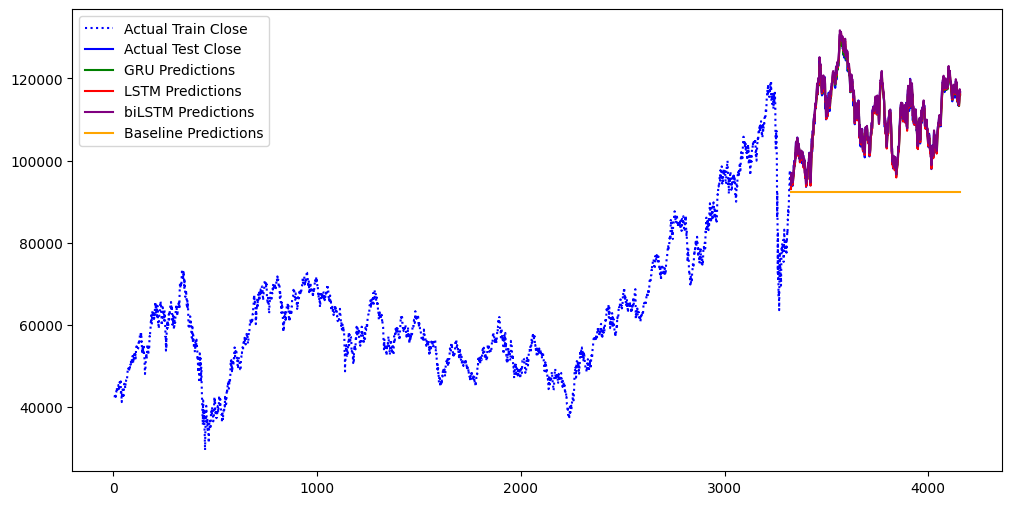

In [32]:
 #Inverse transform both train and test data
trainY = closescaler.inverse_transform(trainY.reshape(-1, 1))
testY = closescaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = range(len(data) - len(testY) - len(trainY), len(data) - len(testY))
time_index_test = range(len(data) - len(testY), len(data))

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, trainY, label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, testY, label='Actual Test Close', color='blue')
plt.plot(time_index_test, gru_predictions, label='GRU Predictions', color='green')
plt.plot(time_index_test, lstm_predictions, label='LSTM Predictions', color='red')
plt.plot(time_index_test, bilstm_predictions, label='biLSTM Predictions', color='purple')
plt.plot(time_index_test, baseline_predictions, label='Baseline Predictions', color='orange')
plt.legend()
plt.show()

In [33]:
# Calculate the mean squared error for each model
gru_mse = mean_squared_error(testY, gru_predictions)
lstm_mse = mean_squared_error(testY, lstm_predictions)
bilstm_mse = mean_squared_error(testY, bilstm_predictions)
baseline_mse = mean_squared_error(testY, baseline_predictions)

# Compare the models using Mean Squared Error
print("GRU Model RMSE: ", np.sqrt(gru_mse))
print("LSTM Model RMSE: ", np.sqrt(lstm_mse))
print("biLSTM Model RMSE: ", np.sqrt(bilstm_mse))
print("Baseline Model RMSE: ", np.sqrt(baseline_mse))


GRU Model RMSE:  847.9048789650536
LSTM Model RMSE:  722.8137250457025
biLSTM Model RMSE:  678.3191322584191
Baseline Model RMSE:  20461.22527838694


In [34]:
# Calculate the Mean Absolute Percentage Error (MAPE) for each model
def calculate_mape(true_values, predicted_values):
    abs_percentage_errors = np.abs((true_values - predicted_values) / true_values)
    mape = np.mean(abs_percentage_errors) * 100  # Convert to percentage
    return mape

gru_mape = calculate_mape(testY, gru_predictions)
lstm_mape = calculate_mape(testY, lstm_predictions)
bilstm_mape = calculate_mape(testY, bilstm_predictions)
baseline_mape = calculate_mape(testY, baseline_predictions)

# Compare the models using Mean Absolute Percentage Error
print("GRU Model MAPE: {:.2f}%".format(gru_mape))
print("LSTM Model MAPE: {:.2f}%".format(lstm_mape))
print("biLSTM Model MAPE: {:.2f}%".format(bilstm_mape))
print("Baseline Model MAPE: {:.2f}%".format(baseline_mape))


GRU Model MAPE: 0.61%
LSTM Model MAPE: 0.52%
biLSTM Model MAPE: 0.49%
Baseline Model MAPE: 16.45%


In [35]:
def calculate_mae(true_values, predicted_values):
    abs_errors = np.abs(true_values - predicted_values)
    mae = np.mean(abs_errors)
    return mae

gru_mae = calculate_mae(testY, gru_predictions)
lstm_mae = calculate_mae(testY, lstm_predictions)
bilstm_mae = calculate_mae(testY, bilstm_predictions)
baseline_mae = calculate_mae(testY, baseline_predictions)

# Compare the models using Mean Absolute Percentage Error
print("GRU Model MAE: {:.2f}".format(gru_mae))
print("LSTM Model MAE: {:.2f}".format(lstm_mae))
print("biLSTM Model MAE: {:.2f}".format(bilstm_mae))
print("Baseline Model MAE: {:.2f}".format(baseline_mae))

GRU Model MAE: 680.52
LSTM Model MAE: 580.94
biLSTM Model MAE: 544.13
Baseline Model MAE: 18785.93


In [36]:
# Calculate the MASE for each model
def calculate_mase(model_mae, baseline_mae):
    mase = model_mae / baseline_mae
    return mase

gru_mase = calculate_mase(gru_mae, baseline_mae)
lstm_mase = calculate_mase(lstm_mae, baseline_mae)
bilstm_mase = calculate_mase(bilstm_mae, baseline_mae)

# Compare the models using Mean Absolute Scaled Error
print("GRU Model MASE: {:.2f}".format(gru_mase))
print("LSTM Model MASE: {:.2f}".format(lstm_mase))
print("biLSTM Model MASE: {:.2f}".format(bilstm_mase))

GRU Model MASE: 0.04
LSTM Model MASE: 0.03
biLSTM Model MASE: 0.03


# Shap

In [37]:
sample_train = trainX.copy()
gru_explainer = shap.DeepExplainer(lstm_model, data=sample_train)  # Substitua 10 pelo número desejado de exemplos para a baseline

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [38]:
# Calcular os valores SHAP
sample = testX.copy()


In [39]:
sample = sample.reshape(831,14)

In [40]:
shap_values = gru_explainer.shap_values(sample)



In [41]:
print(shap_values[0].shape)
shap_values[0]

(831, 14)


array([[ 0.02299152,  0.06889747,  0.09699655, ..., -0.00426118,
        -0.01748746,  0.00095937],
       [ 0.02419137,  0.07145797,  0.09904589, ..., -0.00295386,
        -0.01569845,  0.00229325],
       [ 0.02548204,  0.07129773,  0.10182881, ..., -0.00126063,
        -0.0138864 ,  0.00313811],
       ...,
       [ 0.04210826,  0.10818632,  0.1705304 , ...,  0.00996388,
        -0.02171676,  0.01256906],
       [ 0.04421969,  0.10739728,  0.17322261, ...,  0.00297505,
        -0.0221177 ,  0.01289739],
       [ 0.04191312,  0.10936803,  0.17014773, ...,  0.00771099,
        -0.02333121,  0.01140249]])

In [42]:
sample

array([[0.6987346 , 0.72334389, 0.70993425, ..., 0.72426271, 0.74713907,
        0.75710655],
       [0.71143301, 0.73917583, 0.72283559, ..., 0.70327328, 0.72426271,
        0.74713907],
       [0.73381063, 0.74483901, 0.7359963 , ..., 0.70327328, 0.70327328,
        0.72426271],
       ...,
       [0.96901987, 0.97169544, 0.97883234, ..., 0.93069384, 0.93427902,
        0.93219229],
       [0.97249417, 0.97136631, 0.97237039, ..., 0.94052812, 0.93069384,
        0.93427902],
       [0.95817516, 0.96949372, 0.97352069, ..., 0.95147237, 0.94052812,
        0.93069384]])

In [43]:
columnnames = lagged_data.columns[1:].values

In [44]:
columnnames = np.delete(columnnames, 3)
columnnames

array(['Open', 'High', 'Low', 'Adj Close', 'Volume', '4_observance',
       '4_optional', '4_public', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'lag6'], dtype=object)

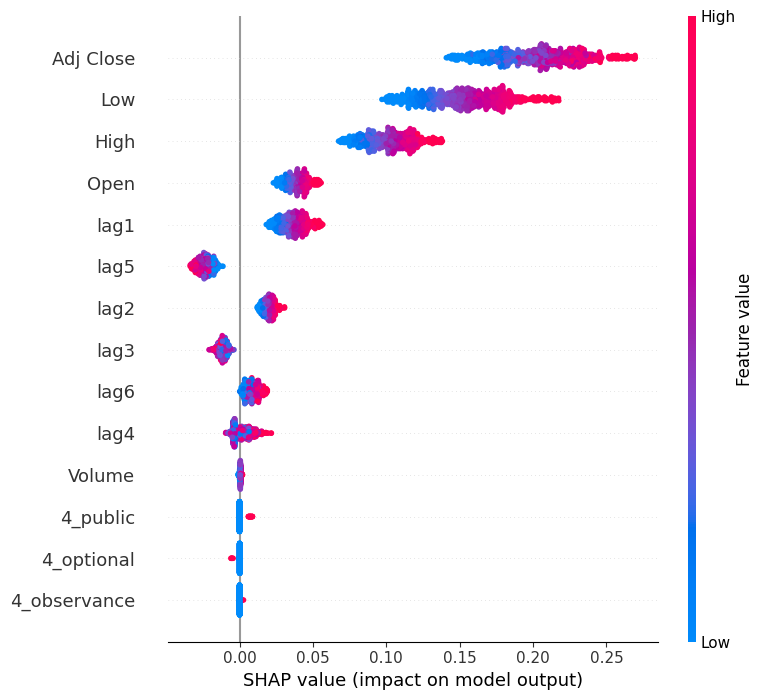

In [45]:
# Visualizar as contribuições
shap.summary_plot(
  shap_values[0],
  sample,
  feature_names=columnnames
)

In [46]:
trainX.reshape(trainX.shape[0],-1)[0]

array([0.13944944, 0.12320543, 0.1334228 , 0.14319647, 0.47685083,
       0.        , 0.        , 0.        , 0.13954469, 0.1486797 ,
       0.14218641, 0.16188827, 0.16660562, 0.17701708])

In [47]:
from lime.lime_tabular import LimeTabularExplainer

# Criando um explainer do Lime
explainer = LimeTabularExplainer(trainX,
                                 mode="regression",
                                 feature_names=columnnames,
                                 class_names=['ibv'],
                                 categorical_features=[[5,6,7]],
                                 discretize_continuous=True)

325


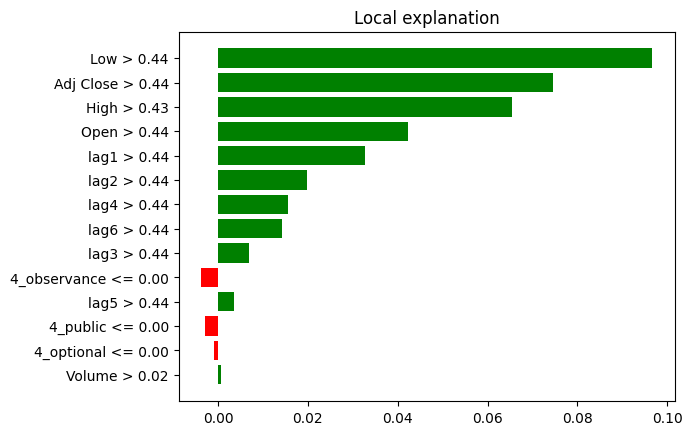

In [48]:
sample_idx = np.random.choice(range(len(testX)), size=(1,))[0]
print(sample_idx)
X_sample = testX[sample_idx]

# Explicação do modelo usando o explainer do Lime
explanation = explainer.explain_instance(X_sample,
                                         gru_model.predict,
                                         num_features=(14))

# Visualizando a explicação
fig = explanation.as_pyplot_figure()
plt.show()

In [49]:
X_sample

array([0.8992785 , 0.89809676, 0.88803807, 0.90045842, 0.05717255,
       0.        , 0.        , 0.        , 0.89932625, 0.89860478,
       0.92643158, 0.90510916, 0.90652992, 0.89561897])

In [ ]:
# Assuming gru_predictions is your NumPy array
baseline_predictions = baseline_predictions.reshape(-1, 1)  # Reshape the array to have one column

# Create a DataFrame
df = pd.DataFrame(data=baseline_predictions, columns=['BASELINE_Predictions'])

# Save the DataFrame to a CSV file
df.to_csv('baseline_predictions.csv', index=False)

In [ ]:
# Assuming gru_predictions is your NumPy array
gru_predictions = gru_predictions.reshape(-1, 1)  # Reshape the array to have one column

# Create a DataFrame
df = pd.DataFrame(data=gru_predictions, columns=['GRU_Predictions'])

# Save the DataFrame to a CSV file
df.to_csv('gru_predictions.csv', index=False)

In [ ]:
# Assuming gru_predictions is your NumPy array
lstm_predictions = lstm_predictions.reshape(-1, 1)  # Reshape the array to have one column

# Create a DataFrame
df = pd.DataFrame(data=lstm_predictions, columns=['LSTM_Predictions'])

# Save the DataFrame to a CSV file
df.to_csv('lstm_predictions.csv', index=False)

In [ ]:
# Assuming gru_predictions is your NumPy array
trainY_predictions = trainY

# Create a DataFrame
df = pd.DataFrame(data=trainY_predictions, columns=['trainY_predictions'])

# Save the DataFrame to a CSV file
df.to_csv('trainY_predictions.csv', index=False)

In [ ]:
# Assuming gru_predictions is your NumPy array
testY_predictions = testY

# Create a DataFrame
df = pd.DataFrame(data=testY_predictions, columns=['testY_predictions'])

# Save the DataFrame to a CSV file
df.to_csv('testY_predictions.csv', index=False)

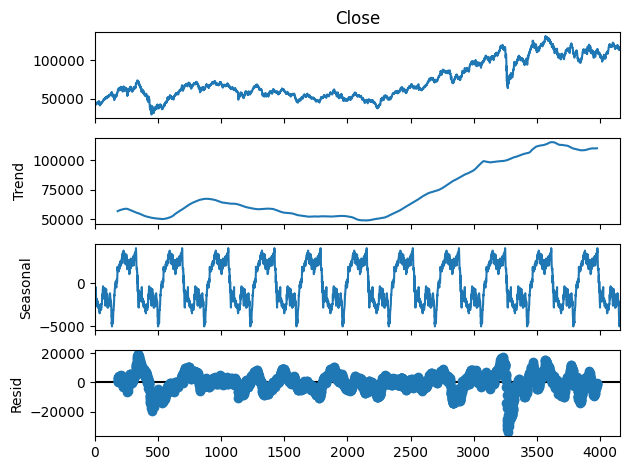

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Close'], model='additive',period=365)
result.plot()
plt.show()

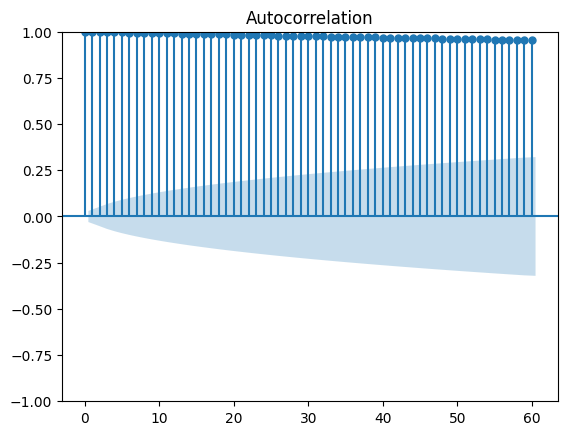

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['Close'], lags=60)
plt.show()

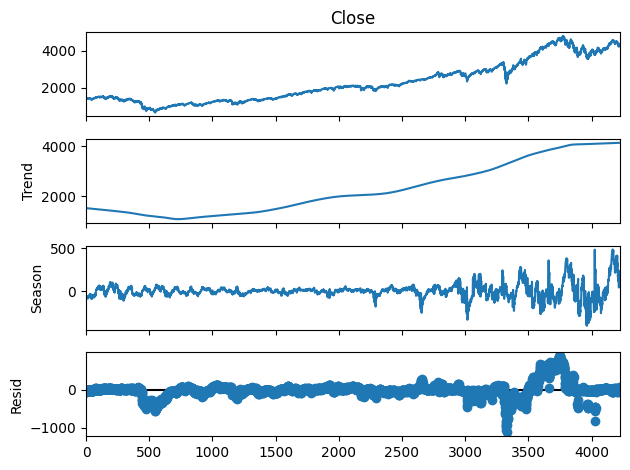

In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(data['Close'], period=365,robust=True)#looking for pattern that repeats annualy
res = stl.fit()
fig = res.plot()

Amplitudes d Decomposição de Fourier, interpretações:

 - https://pressbooks.pub/sound/chapter/frequency-domain-graphs-2/
 - https://medium.com/intuition/quantamental-approach-to-stock-trading-using-the-fourier-analysis-58f64792290
 - https://www.marketinout.com/technical_analysis.php?t=Fourier_Transform&id=51

(0.0, 163.95)

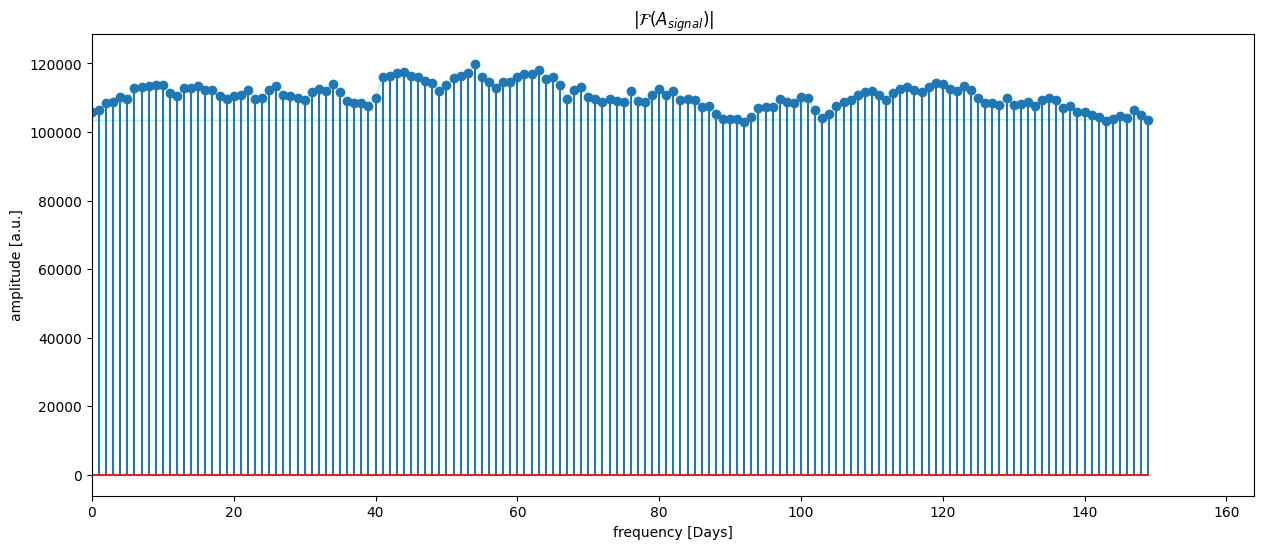

In [ ]:
import scipy.fft
Fs = 300 # Sampling rate
t  = np.arange(0,1,1/Fs)

A_signal_fft = scipy.fft.fft((data[['Close']][len(data[[ 'Close']])-300:]))
frequencies = scipy.fft.fftfreq(np.size(t), 1/Fs)

fig=plt.figure(2, figsize=(15,6))
plt.clf()
plt.plot(frequencies, np.abs(A_signal_fft), lw=1.0, c='paleturquoise')
plt.stem(frequencies, np.abs(A_signal_fft))
plt.xlabel("frequency [Days]")
plt.ylabel("amplitude [a.u.]")
plt.title(r"$|\mathcal{F}(A_{signal})|$")

# Set x-axis limit to values greater than or equal to 0
plt.xlim(0, None)

Forecasting value 1 and 2

In [ ]:
import yfinance as yf
# Download data for the stock (I'm using the Bovespa index as an example)
data3 = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data3 = data3[['Close']]

# Create lag features for the entire dataset
look_back = 6
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data2 = create_lagged_dataframe(data3, look_back, include_lag0)
#lagged_data2 = lagged_data.dropna()  # Drop rows with NaN values
lagged_data2

[*********************100%%**********************]  1 of 1 completed


,Close,lag1,lag2,lag3,lag4,lag5,lag6
Date,,,,,,,
2007-01-02,45383.0,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-03,44445.0,45383.0,NaN,NaN,NaN,NaN,NaN
2007-01-04,44020.0,44445.0,45383.0,NaN,NaN,NaN,NaN
2007-01-05,42245.0,44020.0,44445.0,45383.0,NaN,NaN,NaN
2007-01-08,42830.0,42245.0,44020.0,44445.0,45383.0,NaN,NaN
...,...,...,...,...,...,...,...
2023-10-09,115156.0,114170.0,113284.0,113607.0,113419.0,115057.0,116565.0
2023-10-10,116737.0,115156.0,114170.0,113284.0,113607.0,113419.0,115057.0
2023-10-11,117051.0,116737.0,115156.0,114170.0,113284.0,113607.0,113419.0


In [ ]:
# Save the final dataframe to a CSV file
lagged_data2.to_csv('final_data.csv', index=False)  # Setting index=False to exclude the index column

# Print the first few rows of the final dataframe
print(lagged_data2.head(7))

              Close     lag1     lag2     lag3     lag4     lag5     lag6
Date                                                                     
2007-01-02  45383.0      NaN      NaN      NaN      NaN      NaN      NaN
2007-01-03  44445.0  45383.0      NaN      NaN      NaN      NaN      NaN
2007-01-04  44020.0  44445.0  45383.0      NaN      NaN      NaN      NaN
2007-01-05  42245.0  44020.0  44445.0  45383.0      NaN      NaN      NaN
2007-01-08  42830.0  42245.0  44020.0  44445.0  45383.0      NaN      NaN
2007-01-09  42007.0  42830.0  42245.0  44020.0  44445.0  45383.0      NaN
2007-01-10  42336.0  42007.0  42830.0  42245.0  44020.0  44445.0  45383.0


[*********************100%%**********************]  1 of 1 completed
   Feature  Importance
0     lag1    0.997551
1     lag2    0.000477
14   lag15    0.000092
2     lag3    0.000082
7     lag8    0.000078
23   lag24    0.000066
4     lag5    0.000063
37   lag38    0.000061
16   lag17    0.000057
5     lag6    0.000057


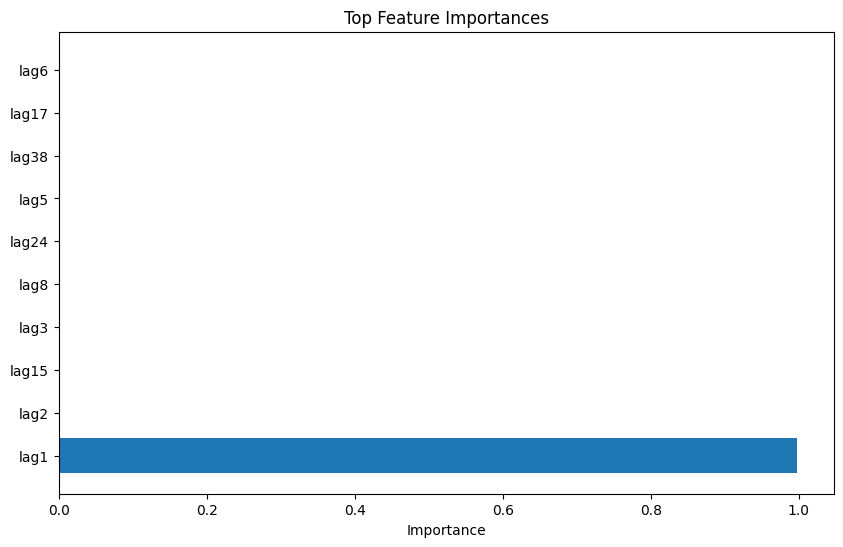

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Download data for the stock (I'm using the Bovespa index as an example)
data3 = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data3 = data3[['Close']]

# Create lag features for the entire dataset
look_back = 60
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data = create_lagged_dataframe(data3, look_back, include_lag0)
lagged_data = lagged_data.dropna()  # Drop rows with NaN values
lagged_data

# Split the data into features (X) and the target variable (Y)
X = lagged_data.drop(columns='Close')
Y = lagged_data['Close']

# Create and fit the Decision Tree model
regression_tree = DecisionTreeRegressor()
regression_tree.fit(X, Y)

# Calculate feature importances
feature_importances = regression_tree.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features (adjust N as needed)
top_n = 10
print(importance_df.head(top_n))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:top_n], importance_df['Importance'][:top_n])
plt.xlabel('Importance')
plt.title('Top Feature Importances')
plt.show()
#lag1 is way more important than others

In [ ]:
testX.shape

(844, 6)

# Proximos 3 dias

In [ ]:
look_back=6

In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2 = yf.download('^GSPC', '2007-01-01', '2023-10-17')


datacheck = yf.download('^GSPC', '2007-01-01', '2023-10-17')
datacheck= datacheck[['Close']]

# Define the baseline model
def baseline_model(output_window):
    last_known_value = np.array(datacheck)[-1]
    return np.full((3, output_window), last_known_value)

# Train and evaluate the models
output_window = 1

baseline_predictions = baseline_model(output_window)

data2['Close'] = scaler.fit_transform(data2['Close'].values.reshape(-1, 1))
data2= data2[['Close']]

last_60_days = data2[-look_back:].values
last_60_days_scaled = last_60_days
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = X_test.reshape(-1,1,X_test.shape[1])
X_test
#pred_price = lstm_model.predict(X_test)
#pred_price = scaler.inverse_transform(pred_price)
#print(pred_price)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


array([[[0.88813191, 0.89361247, 0.89815369, 0.89151773, 0.88621921,
         0.89734779]]])

In [ ]:
# Use the last available data in the test set for initial prediction
current_input = X_test
# Use the last available data in the test set for initial prediction
current_input_GRU = X_test
# Use the last available data in the test set for initial prediction
current_input_bilstm = X_test

num_steps=3
# List to store multi-step predictions
multi_step_preds = []
multi_step_preds_GRU = []
multi_step_preds_bilstm = []

for step in range(num_steps):
    # Reshape current input for prediction

    # Make prediction for the next step
    next_step_pred = lstm_model.predict(current_input)
    # Make prediction for the next step
    next_step_pred_GRU = gru_model.predict(current_input_GRU)
    # Make prediction for the next step
    next_step_pred_bilstm = bilstm_model.predict(current_input_bilstm)


    # Append prediction to the list
    multi_step_preds.append(next_step_pred[0, 0])
    # Append prediction to the list
    multi_step_preds_GRU.append(next_step_pred_GRU[0, 0])
    # Append prediction to the list
    multi_step_preds_bilstm.append(next_step_pred_bilstm[0, 0])

     # Update current input for the next iteration
    current_input = np.concatenate([current_input[:, 0:, :], next_step_pred.reshape(1, 1, 1)], axis=2)[:,:,1:]
     # Update current input for the next iteration
    current_input_GRU = np.concatenate([current_input_GRU[:, 0:, :], next_step_pred_GRU.reshape(1, 1, 1)], axis=2)[:,:,1:]
# Update current input for the next iteration
    current_input_bilstm = np.concatenate([current_input_bilstm[:, 0:, :], next_step_pred_bilstm.reshape(1, 1, 1)], axis=2)[:,:,1:]


    #print(current_input)

# Inverse transform the predictions
multi_step_preds = scaler.inverse_transform(np.array(multi_step_preds).reshape(-1, 1))
multi_step_preds

multi_step_preds_GRU = scaler.inverse_transform(np.array(multi_step_preds_GRU).reshape(-1, 1))
multi_step_preds_GRU

multi_step_preds_bilstm = scaler.inverse_transform(np.array(multi_step_preds_bilstm).reshape(-1, 1))
multi_step_preds_bilstm

array([[4342.7974],
       [4372.6426],
       [4370.9717]], dtype=float32)

In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2test = yf.download('^GSPC', '2023-10-18', '2023-10-21')
data2test= data2test[['Close']]
len(data2test)

[*********************100%%**********************]  1 of 1 completed


3

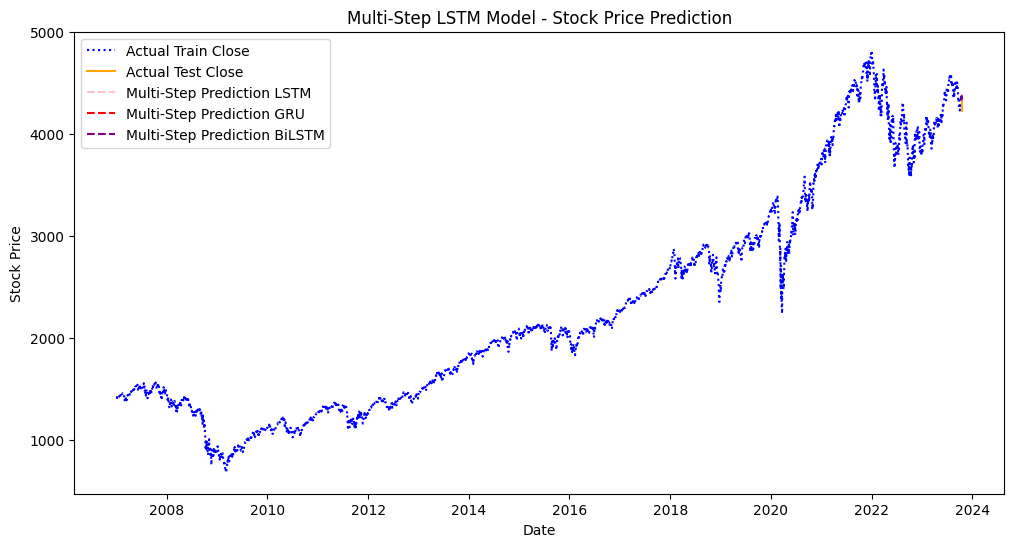

In [ ]:
# Generate future dates for the multi-step prediction
#last_date = lagged_data.index[-1]
#future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_steps)


#Inverse transform both train and test data
#trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
#testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = data2.index
time_index_test = data2test.index

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, datacheck, label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, data2test, label='Actual Test Close', color='orange')

# Plot the multi-step predictions
#plt.figure(figsize=(12, 6))
#plt.plot(data.index, data['Close'], label='Historical Data')
plt.plot(time_index_test, multi_step_preds, label='Multi-Step Prediction LSTM', linestyle='dashed',color='pink')
plt.plot(time_index_test, multi_step_preds_GRU, label='Multi-Step Prediction GRU', linestyle='dashed',color='red')
plt.plot(time_index_test, multi_step_preds_bilstm, label='Multi-Step Prediction BiLSTM', linestyle='dashed',color='purple')

plt.title('Multi-Step LSTM Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
test_to_errors=np.array(data2test[['Close']])

baseline_mae = calculate_mae(test_to_errors, baseline_predictions)

lstm_mape15 = calculate_mape(test_to_errors, multi_step_preds)
lstm_mae15 = calculate_mae(test_to_errors, multi_step_preds)
lstm_mase15 = calculate_mase(lstm_mae15,baseline_mae)
lstm_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds))

gru_mape15 = calculate_mape(test_to_errors, multi_step_preds_GRU)
gru_mae15 = calculate_mae(test_to_errors, multi_step_preds_GRU)
gru_mase15 = calculate_mase(gru_mae15,baseline_mae)
gru_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds_GRU))


bilstm_mape15 = calculate_mape(test_to_errors, multi_step_preds_bilstm)
bilstm_mae15 = calculate_mae(test_to_errors, multi_step_preds_bilstm)
bilstm_mase15 = calculate_mase(bilstm_mae15,baseline_mae)
bilstm_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds_bilstm))




print("LSTM Model MAPE: {:.2f}%".format(lstm_mape15))
print("LSTM Model MASE: {:.2f}".format(lstm_mase15))
print("LSTM Model RMSE: {:.2f}".format(lstm_rmse15))

print("GRU Model MAPE: {:.2f}%".format(gru_mape15))
print("GRU Model MASE: {:.2f}".format(gru_mase15))
print("GRU Model RMSE: {:.2f}".format(gru_rmse15))

print("biLSTM Model MAPE: {:.2f}%".format(bilstm_mape15))
print("biLSTM Model MASE: {:.2f}".format(bilstm_mase15))
print("biLSTM Model RMSE: {:.2f}".format(bilstm_rmse15))

print("baseline Model MAE: {:.2f}".format(baseline_mae))


LSTM Model MAPE: 2.42%
LSTM Model MASE: 1.02
LSTM Model RMSE: 113.18
GRU Model MAPE: 1.78%
GRU Model MASE: 0.75
GRU Model RMSE: 89.98
biLSTM Model MAPE: 2.11%
biLSTM Model MASE: 0.89
biLSTM Model RMSE: 102.15
baseline Model MAE: 101.38


# Proximos 7 dias

In [ ]:
look_back=6

In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2 = yf.download('^GSPC', '2007-01-01', '2023-10-17')
datacheck = yf.download('^GSPC', '2007-01-01', '2023-10-17')
datacheck= datacheck[['Close']]

# Define the baseline model
def baseline_model(output_window):
    last_known_value = np.array(datacheck)[-1]
    return np.full((7, output_window), last_known_value)

# Train and evaluate the models
output_window = 1

baseline_predictions = baseline_model(output_window)

data2['Close'] = scaler.fit_transform(data2['Close'].values.reshape(-1, 1))
data2= data2[['Close']]

last_60_days = data2[-look_back:].values
last_60_days_scaled = last_60_days
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = X_test.reshape(-1,1,X_test.shape[1])
X_test
#pred_price = lstm_model.predict(X_test)
#pred_price = scaler.inverse_transform(pred_price)
#print(pred_price)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


array([[[0.88813191, 0.89361247, 0.89815369, 0.89151773, 0.88621921,
         0.89734779]]])

In [ ]:
# Use the last available data in the test set for initial prediction
current_input = X_test
# Use the last available data in the test set for initial prediction
current_input_GRU = X_test
# Use the last available data in the test set for initial prediction
current_input_bilstm = X_test

num_steps=7
# List to store multi-step predictions
multi_step_preds = []
multi_step_preds_GRU = []
multi_step_preds_bilstm = []

for step in range(num_steps):
    # Reshape current input for prediction

    # Make prediction for the next step
    next_step_pred = lstm_model.predict(current_input)
    # Make prediction for the next step
    next_step_pred_GRU = gru_model.predict(current_input_GRU)
    # Make prediction for the next step
    next_step_pred_bilstm = bilstm_model.predict(current_input_bilstm)


    # Append prediction to the list
    multi_step_preds.append(next_step_pred[0, 0])
    # Append prediction to the list
    multi_step_preds_GRU.append(next_step_pred_GRU[0, 0])
    # Append prediction to the list
    multi_step_preds_bilstm.append(next_step_pred_bilstm[0, 0])

     # Update current input for the next iteration
    current_input = np.concatenate([current_input[:, 0:, :], next_step_pred.reshape(1, 1, 1)], axis=2)[:,:,1:]
     # Update current input for the next iteration
    current_input_GRU = np.concatenate([current_input_GRU[:, 0:, :], next_step_pred_GRU.reshape(1, 1, 1)], axis=2)[:,:,1:]
# Update current input for the next iteration
    current_input_bilstm = np.concatenate([current_input_bilstm[:, 0:, :], next_step_pred_bilstm.reshape(1, 1, 1)], axis=2)[:,:,1:]


    #print(current_input)

# Inverse transform the predictions
multi_step_preds = scaler.inverse_transform(np.array(multi_step_preds).reshape(-1, 1))
multi_step_preds

multi_step_preds_GRU = scaler.inverse_transform(np.array(multi_step_preds_GRU).reshape(-1, 1))
multi_step_preds_GRU

multi_step_preds_bilstm = scaler.inverse_transform(np.array(multi_step_preds_bilstm).reshape(-1, 1))
multi_step_preds_bilstm

array([[4342.7974],
       [4372.6426],
       [4370.9717],
       [4347.602 ],
       [4341.9634],
       [4367.5083],
       [4354.1753]], dtype=float32)

In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2test = yf.download('^GSPC', '2023-10-18', '2023-10-27')
data2test= data2test[['Close']]
len(data2test)

[*********************100%%**********************]  1 of 1 completed


7

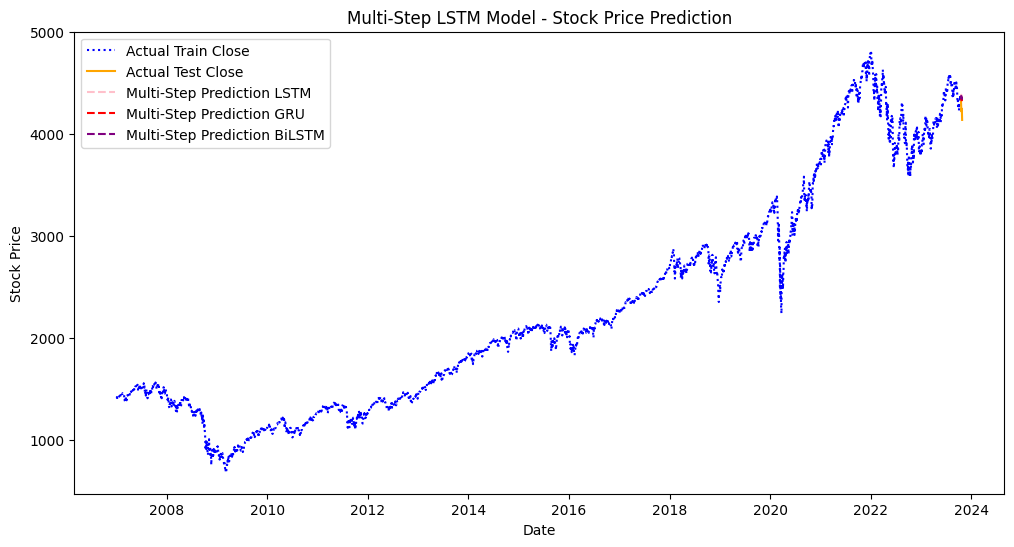

In [ ]:
# Generate future dates for the multi-step prediction
#last_date = lagged_data.index[-1]
#future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_steps)


#Inverse transform both train and test data
#trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
#testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = data2.index
time_index_test = data2test.index

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, datacheck, label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, data2test, label='Actual Test Close', color='orange')

# Plot the multi-step predictions
#plt.figure(figsize=(12, 6))
#plt.plot(data.index, data['Close'], label='Historical Data')
plt.plot(time_index_test, multi_step_preds, label='Multi-Step Prediction LSTM', linestyle='dashed',color='pink')
plt.plot(time_index_test, multi_step_preds_GRU, label='Multi-Step Prediction GRU', linestyle='dashed',color='red')
plt.plot(time_index_test, multi_step_preds_bilstm, label='Multi-Step Prediction BiLSTM', linestyle='dashed',color='purple')

plt.title('Multi-Step LSTM Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
test_to_errors=np.array(data2test[['Close']])

baseline_mae = calculate_mae(test_to_errors, baseline_predictions)
lstm_mape15 = calculate_mape(test_to_errors, multi_step_preds)
lstm_mae15 = calculate_mae(test_to_errors, multi_step_preds)
lstm_mase15 = calculate_mase(lstm_mae15,baseline_mae)
lstm_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds))

gru_mape15 = calculate_mape(test_to_errors, multi_step_preds_GRU)
gru_mae15 = calculate_mae(test_to_errors, multi_step_preds_GRU)
gru_mase15 = calculate_mase(gru_mae15,baseline_mae)
gru_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds_GRU))



bilstm_mape15 = calculate_mape(test_to_errors, multi_step_preds_bilstm)
bilstm_mae15 = calculate_mae(test_to_errors, multi_step_preds_bilstm)
bilstm_mase15 = calculate_mase(bilstm_mae15,baseline_mae)
bilstm_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds_bilstm))




print("LSTM Model MAPE: {:.2f}%".format(lstm_mape15))
print("LSTM Model MASE: {:.2f}".format(lstm_mase15))
print("LSTM Model RMSE: {:.2f}".format(lstm_rmse15))

print("GRU Model MAPE: {:.2f}%".format(gru_mape15))
print("GRU Model MASE: {:.2f}".format(gru_mase15))
print("GRU Model RMSE: {:.2f}".format(gru_rmse15))

print("biLSTM Model MAPE: {:.2f}%".format(bilstm_mape15))
print("biLSTM Model MASE: {:.2f}".format(bilstm_mase15))
print("biLSTM Model RMSE: {:.2f}".format(bilstm_rmse15))

print("baseline Model MAE: {:.2f}".format(baseline_mae))

LSTM Model MAPE: 3.40%
LSTM Model MASE: 0.99
LSTM Model RMSE: 155.89
GRU Model MAPE: 2.65%
GRU Model MASE: 0.77
GRU Model RMSE: 123.94
biLSTM Model MAPE: 3.03%
biLSTM Model MASE: 0.88
biLSTM Model RMSE: 139.88
baseline Model MAE: 144.28


# Proximos 15 dias (LSTM)

In [ ]:
look_back=6

In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2 = yf.download('^GSPC', '2007-01-01', '2023-10-17')
datacheck = yf.download('^GSPC', '2007-01-01', '2023-10-17')
datacheck= datacheck[['Close']]
# Define the baseline model
def baseline_model(output_window):
    last_known_value = np.array(datacheck)[-1]
    return np.full((15, output_window), last_known_value)

# Train and evaluate the models
output_window = 1

baseline_predictions = baseline_model(output_window)

data2['Close'] = scaler.fit_transform(data2['Close'].values.reshape(-1, 1))
data2= data2[['Close']]

last_60_days = data2[-look_back:].values
last_60_days_scaled = last_60_days
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = X_test.reshape(-1,1,X_test.shape[1])
X_test
#pred_price = lstm_model.predict(X_test)
#pred_price = scaler.inverse_transform(pred_price)
#print(pred_price)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


array([[[0.88813191, 0.89361247, 0.89815369, 0.89151773, 0.88621921,
         0.89734779]]])

In [ ]:
# Use the last available data in the test set for initial prediction
current_input = X_test
# Use the last available data in the test set for initial prediction
current_input_GRU = X_test
# Use the last available data in the test set for initial prediction
current_input_bilstm = X_test

num_steps=15
# List to store multi-step predictions
multi_step_preds = []
multi_step_preds_GRU = []
multi_step_preds_bilstm = []

for step in range(num_steps):
    # Reshape current input for prediction

    # Make prediction for the next step
    next_step_pred = lstm_model.predict(current_input)
    # Make prediction for the next step
    next_step_pred_GRU = gru_model.predict(current_input_GRU)
    # Make prediction for the next step
    next_step_pred_bilstm = bilstm_model.predict(current_input_bilstm)


    # Append prediction to the list
    multi_step_preds.append(next_step_pred[0, 0])
    # Append prediction to the list
    multi_step_preds_GRU.append(next_step_pred_GRU[0, 0])
    # Append prediction to the list
    multi_step_preds_bilstm.append(next_step_pred_bilstm[0, 0])

     # Update current input for the next iteration
    current_input = np.concatenate([current_input[:, 0:, :], next_step_pred.reshape(1, 1, 1)], axis=2)[:,:,1:]
     # Update current input for the next iteration
    current_input_GRU = np.concatenate([current_input_GRU[:, 0:, :], next_step_pred_GRU.reshape(1, 1, 1)], axis=2)[:,:,1:]
# Update current input for the next iteration
    current_input_bilstm = np.concatenate([current_input_bilstm[:, 0:, :], next_step_pred_bilstm.reshape(1, 1, 1)], axis=2)[:,:,1:]


    #print(current_input)

# Inverse transform the predictions
multi_step_preds = scaler.inverse_transform(np.array(multi_step_preds).reshape(-1, 1))
multi_step_preds

multi_step_preds_GRU = scaler.inverse_transform(np.array(multi_step_preds_GRU).reshape(-1, 1))
multi_step_preds_GRU

multi_step_preds_bilstm = scaler.inverse_transform(np.array(multi_step_preds_bilstm).reshape(-1, 1))
multi_step_preds_bilstm

array([[4342.7974],
       [4372.6426],
       [4370.9717],
       [4347.602 ],
       [4341.9634],
       [4367.5083],
       [4354.1753],
       [4379.8145],
       [4366.6714],
       [4349.662 ],
       [4350.059 ],
       [4366.5767],
       [4365.6655],
       [4382.775 ],
       [4364.5186]], dtype=float32)

In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2test = yf.download('^GSPC', '2023-10-19', '2023-11-09')
data2test= data2test[['Close']]
len(data2test)

[*********************100%%**********************]  1 of 1 completed


15

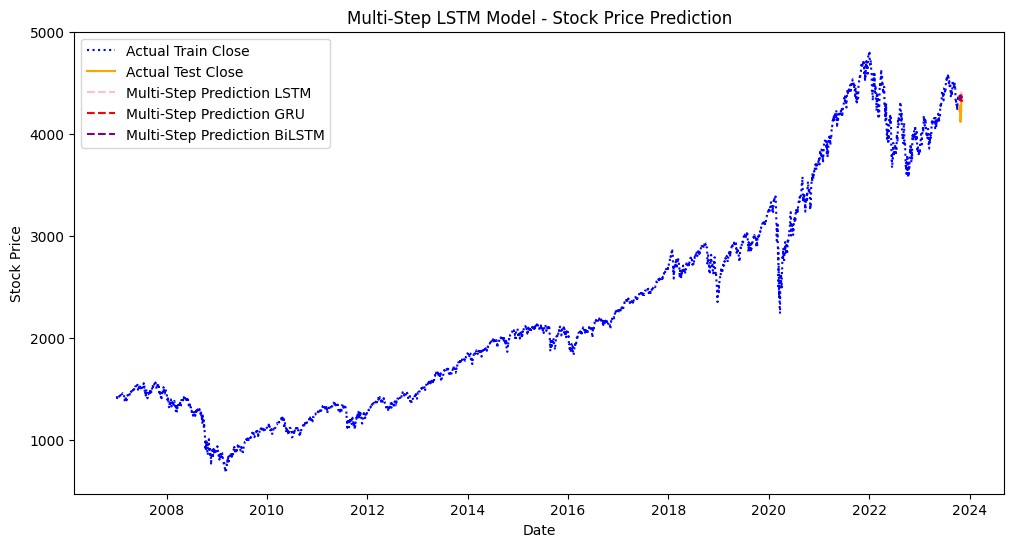

In [ ]:
# Generate future dates for the multi-step prediction
#last_date = lagged_data.index[-1]
#future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_steps)


#Inverse transform both train and test data
#trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
#testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = data2.index
time_index_test = data2test.index

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, datacheck, label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, data2test, label='Actual Test Close', color='orange')

# Plot the multi-step predictions
#plt.figure(figsize=(12, 6))
#plt.plot(data.index, data['Close'], label='Historical Data')
plt.plot(time_index_test, multi_step_preds, label='Multi-Step Prediction LSTM', linestyle='dashed',color='pink')
plt.plot(time_index_test, multi_step_preds_GRU, label='Multi-Step Prediction GRU', linestyle='dashed',color='red')
plt.plot(time_index_test, multi_step_preds_bilstm, label='Multi-Step Prediction BiLSTM', linestyle='dashed',color='purple')

plt.title('Multi-Step LSTM Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
test_to_errors=np.array(data2test[['Close']])

baseline_mae = calculate_mae(test_to_errors, baseline_predictions)

lstm_mape15 = calculate_mape(test_to_errors, multi_step_preds)
lstm_mae15 = calculate_mae(test_to_errors, multi_step_preds)
lstm_mase15 = calculate_mase(lstm_mae15,baseline_mae)
lstm_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds))

gru_mape15 = calculate_mape(test_to_errors, multi_step_preds_GRU)
gru_mae15 = calculate_mae(test_to_errors, multi_step_preds_GRU)
gru_mase15 = calculate_mase(gru_mae15,baseline_mae)
gru_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds_GRU))


bilstm_mape15 = calculate_mape(test_to_errors, multi_step_preds_bilstm)
bilstm_mae15 = calculate_mae(test_to_errors, multi_step_preds_bilstm)
bilstm_mase15 = calculate_mase(bilstm_mae15,baseline_mae)
bilstm_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds_bilstm))




print("LSTM Model MAPE: {:.2f}%".format(lstm_mape15))
print("LSTM Model MASE: {:.2f}".format(lstm_mase15))
print("LSTM Model RMSE: {:.2f}".format(lstm_rmse15))

print("GRU Model MAPE: {:.2f}%".format(gru_mape15))
print("GRU Model MASE: {:.2f}".format(gru_mase15))
print("GRU Model RMSE: {:.2f}".format(gru_rmse15))

print("biLSTM Model MAPE: {:.2f}%".format(bilstm_mape15))
print("biLSTM Model MASE: {:.2f}".format(bilstm_mase15))
print("biLSTM Model RMSE: {:.2f}".format(bilstm_rmse15))

print("baseline Model MAE: {:.2f}".format(baseline_mae))

LSTM Model MAPE: 3.12%
LSTM Model MASE: 1.08
LSTM Model RMSE: 153.64
GRU Model MAPE: 2.48%
GRU Model MASE: 0.86
GRU Model RMSE: 123.13
biLSTM Model MAPE: 2.63%
biLSTM Model MASE: 0.91
biLSTM Model RMSE: 137.19
baseline Model MAE: 121.48
